In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


import sys, os, functools, re,  datetime, time, gc, json, pickle, pyarrow as pa, pyarrow.parquet as pq
from functools import reduce
import numpy as np, pandas as pd, itertools

from tqdm import tqdm

import seaborn as sns; sns.set()
import matplotlib
import matplotlib.pyplot as plt

import uproot

code_path = r"C:\Users\mulugetawa\OneDrive - Universitetet i Agder\CERN\InductionProject\CMS_HCAL_ML_OnlineDQM"
sys.path.append(code_path)
sys.path.append(code_path+"/src")
import utilities as util


%matplotlib inline

In [3]:

# import  rootfile_handler_utils

In [ ]:
# HEHB, 2022
run_profiles = [
     {"pd": "ZeroBias", "id": "Run355456", "year": "2022//cut20fc/HEHB"},
     {"pd": "ZeroBias", "id": "Run355680", "year": "2022//cut20fc/HEHB"},
    {"pd": "ZeroBias", "id": "Run357442", "year": "2022//cut20fc/HEHB"},
    {"pd": "ZeroBias", "id": "Run356381", "year": "2022//cut20fc/HEHB"},
    {"pd": "ZeroBias", "id": "Run357329", "year": "2022//cut20fc/HEHB"},
     {"pd": "ZeroBias", "id": "Run357271", "year": "2022//cut20fc/HEHB"},
     {"pd": "ZeroBias", "id": "Run356615", "year": "2022//cut20fc/HEHB"},
     {"pd": "ZeroBias", "id": "Run356077", "year": "2022//cut20fc/HEHB"},
     {"pd": "ZeroBias", "id": "Run357112", "year": "2022//cut20fc/HEHB"}   
]

In [ ]:
# DQM TH3 histogram to numpy conversion
tree_hist_tag = "Hcal4DQMAnalyzer/hist3D"
root_filename = "output__depth.root"  # for depth data
for run_profile in run_profiles:
    root_to_numpy_dataset_convert(
        root_filename, root_dirpath, np_dirpath=None, run_profile=run_profile, tree_hist_tag=tree_hist_tag)

# evttree/LumiSec
tree_hist_tag = "Hcal4DQMAnalyzer/evttree/LumiSec"  # for event data
root_filename = "output__depth.root"  # from depth data
for run_profile in run_profiles:
    root_to_numpy_dataset_convert(
        root_filename, root_dirpath, np_dirpath=None, run_profile=run_profile, tree_hist_tag=tree_hist_tag)

## Convert Root to Numpy

In [376]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

class TH3UpRootHandler():

    def __init__(self, dqm_variable="QIEDigiOccupancy", run_profile={"id": None, "year": None, "pd": "ZeroBias"}) -> None:
        self.root_loader = "uproot"
        self.run_profile = run_profile
        self.filepath = None
        self.tree_hist_tag = None
        self.meta = {}
        self.meta["xaxis"] = {}
        self.meta["yaxis"] = {}
        self.meta["zaxis"] = {}
        self.meta["dqm_variable"] = dqm_variable

    def load_TFiledata(self, filepath) -> None:
        self.TFileObj, self.filepath = uproot.open(filepath), filepath 

    def extract_TH(self, tree_hist_tag="HcalDigiAnalyzer/hist3D") -> None:
        '''
        TH3Obj : TH3 object
        tree_hist_tag: tree path of the target TH3I node
        extraction of axes info ls x ieta x iphi
        3D hist root into 3D numpy conversion
        :
        '''

        self.TH3Obj = self.TFileObj[tree_hist_tag]

        self.meta["xaxis"]["label"] = "ls"
        self.meta["yaxis"]["label"] = "ieta"
        self.meta["zaxis"]["label"] = "iphi"


        # extract hist dim info
        self.xaxis_N = self.TH3Obj.axis("x").edges().shape[0]
        self.yaxis_N = self.TH3Obj.axis("y").edges().shape[0]
        self.zaxis_N = self.TH3Obj.axis("z").edges().shape[0]
        print("hist dim: {}={}, {}={}, {}={}".format(
            self.meta["xaxis"]["label"], self.xaxis_N, self.meta["yaxis"]["label"], self.yaxis_N, self.meta["zaxis"]["label"], self.zaxis_N))

        self.xaxis_lim = [self.TH3Obj.axis("x").edges().min(),
                          self.TH3Obj.axis("x").edges().max()]
        self.yaxis_lim = [self.TH3Obj.axis("y").edges().min(),
                          self.TH3Obj.axis("y").edges().max()]
        self.zaxis_lim = [self.TH3Obj.axis("z").edges().min(),
                          self.TH3Obj.axis("z").edges().max()]

        print("hist axis index limits: {}={}, {}={}, {}={}".format(
            self.meta["xaxis"]["label"], self.xaxis_lim, self.meta["yaxis"]["label"], self.yaxis_lim, self.meta["zaxis"]["label"], self.zaxis_lim))

        # ls
        self.meta["xaxis"]["values"] = self.TH3Obj.axis("x").edges().astype(int)

        # ieta
        self.meta["yaxis"]["values"] = self.TH3Obj.axis("y").edges().astype(int)
        self.meta["yaxis"]["values"] = self.meta["yaxis"]["values"][self.meta["yaxis"]["values"] !=0]
        
        # iphi
        self.meta["zaxis"]["values"] = self.TH3Obj.axis("z").edges().astype(int)[1:]

    def convert_TH_to_numpy(self):
        # get numpy values
        self.TH3Obj_np = self.TH3Obj.values()
        
        # remove empty ls at the end
        xaxis_3d_idx, yaxis_3d_idx, zaxis_3d_idx = self.TH3Obj_np.nonzero()

        self.meta["xaxis"]["valued_range"] = [
            xaxis_3d_idx.min(), xaxis_3d_idx.max()]
        self.meta["yaxis"]["valued_range"] = [
            yaxis_3d_idx.min(), yaxis_3d_idx.max()]
        self.meta["zaxis"]["valued_range"] = [
            zaxis_3d_idx.min(), zaxis_3d_idx.max()]

    def plot_TH3_np(self, figsize=(6, 8), title=None, **kwargs) -> None:
        cmap = kwargs.pop("cmap", "Spectral_r")
        xaxis_3d_idx, yaxis_3d_idx, zaxis_3d_idx = self.TH3Obj_np.nonzero()

        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
        ax_3d = ax.scatter(self.meta["yaxis"]["values"][yaxis_3d_idx],
                           self.meta["xaxis"]["values"][xaxis_3d_idx],  self.meta["zaxis"]["values"][zaxis_3d_idx], c=self.TH3Obj_np[xaxis_3d_idx, yaxis_3d_idx, zaxis_3d_idx], marker=".", cmap=cmap)
       
        cax = fig.add_axes([ax.get_position().x0,
                        ax.get_position().y0-0.04, ax.get_position().width, 0.02])
        cbar = plt.colorbar(ax_3d, orientation="horizontal", cax=cax, pad=1)

        # cbar = plt.colorbar(ax_3d, fraction=1.0, pad=0.02)
        cbar.set_label(self.meta["dqm_variable"])
        
        ax.set_xlabel(self.meta["yaxis"]["label"])
        ax.set_ylabel(self.meta["xaxis"]["label"])
        ax.set_zlabel(self.meta["zaxis"]["label"])

        ax.set_title("{}_{}".format(title, self.meta["dqm_variable"]))
        fig.show()
    
    def get_th3_numpy(self):
        return self.TH3Obj_np[:self.meta["xaxis"]["valued_range"][-1]+1]

    def get_meta_data(self):
        meta_data = self.meta.copy()
        meta_data["xaxis"]["values"] = meta_data["xaxis"]["values"][:meta_data["xaxis"]["valued_range"][-1]+1]
        return meta_data

In [378]:
def root_th3_with_lumi_to_numpy_convert(TH3RootObj,
                tree_hist_tag="Hcal4DQMAnalyzer/hist3D", depth_size=7, **kwargs):

    print("root_th3_with_lumi_to_numpy_convert...", tree_hist_tag)
    th_dim = kwargs.get("th_dim", 3)
    isplot = kwargs.get("isplot", False)

    if "evttree" in tree_hist_tag:
        # "Hcal4DQMAnalyzer/evttree/LumiSec" for event data
        tree_var = tree_hist_tag.split("/")[-1]
        tree_hist_tag = "/".join(tree_hist_tag.split("/")[:-1])
        TH1Obj = TH3RootObj.TFileObj[tree_hist_tag]
        data = np.array(TH1Obj.arrays()[tree_var])
       
        # bin-method-2
        # similar as root plot
        ls = np.unique(data)
        ls = np.concatenate((ls, ls[-1:]+1))
        num_event_np = np.histogram(data, bins=ls)
        num_event_df = pd.Series(
            num_event_np[0], index=num_event_np[1][:-1].astype(int)).to_frame().reset_index(drop=False)

        num_event_df.columns = ["LS#", "NumEvents"]
        print(num_event_df.shape)
        if isplot and ("LumiSec" in tree_var):
            fig, ax = plt.subplots(figsize=(5, 3))
            ax.plot(num_event_df["LS#"], num_event_df["NumEvents"], color='g')
            plt.title("Number of Events")
            plt.xlabel("ls")
            plt.ylabel("value")
            plt.show()

        return num_event_df
    
    elif "hist3D" in tree_hist_tag:
        # "HcalDigiAnalyzer/hist3D" for digioccupancy data
        
        if th_dim == 2:
            # "Hcal4DQMAnalyzer/hist3D" for hist data 
            TH3RootObj.extract_TH(tree_hist_tag=tree_hist_tag)
            TH3RootObj.convert_TH_to_numpy()
            if isplot:
                TH3RootObj.plot_TH3_np(title="Hist3D")
            TH3Obj_np = TH3RootObj.get_th3_numpy()

        elif th_dim == 3:
            # "Hcal4DQMAnalyzer/hist3D_depthX" for hist data 

            roots_per_depth_list = []
            for depth in range(1, depth_size+1):
                print("{}_depth{}".format(tree_hist_tag, depth))
                TH3RootObj.extract_TH(
                    tree_hist_tag="{}_depth{}".format(tree_hist_tag, depth))
                TH3RootObj.convert_TH_to_numpy()
                if isplot:
                    TH3RootObj.plot_TH3_np(title="Hist3D_Depth_{}".format(depth))
                TH3Obj_np_ = TH3RootObj.get_th3_numpy()
                print(TH3Obj_np_.shape)
                roots_per_depth_list.append(np.expand_dims(TH3Obj_np_, axis=3))
                # break
            TH3Obj_np = np.concatenate(tuple(roots_per_depth_list), axis=3) 
        else:
            raise "Undefined tree_hist_tag: {}. please select [HcalDigiAnalyzer/hist3D or Hcal4DQMAnalyzer/evttree/LumiSec].".format(tree_hist_tag)

        print(TH3Obj_np.shape)
        return TH3Obj_np
    
def rootfile_loader(filepath, depth_size=7, isrun_setting=True, **kwargs):
    print("rootfile_loader..., ", filepath)

    try:
        TH3RootObj = TH3UpRootHandler()
        TH3RootObj.load_TFiledata(filepath=filepath)

        # DQM TH3 histogram to numpy conversion
        tree_hist_tag = "Hcal4DQMAnalyzer/hist3D"
        TH3Obj_np = root_th3_with_lumi_to_numpy_convert(TH3RootObj, tree_hist_tag=tree_hist_tag, depth_size=depth_size, th_dim=3, **kwargs)
        meta_data = TH3RootObj.get_meta_data()

        # evttree/LumiSec
        tree_hist_tag = "Hcal4DQMAnalyzer/evttree/LumiSec"  # for event data
        run_ls_lumi_df = root_th3_with_lumi_to_numpy_convert(TH3RootObj, tree_hist_tag=tree_hist_tag, depth_size=depth_size, th_dim=3, **kwargs)

        # evttree/RunNum
        tree_hist_tag = "Hcal4DQMAnalyzer/evttree/RunNum"  # get runId
        run_num_df = root_th3_with_lumi_to_numpy_convert(TH3RootObj, tree_hist_tag=tree_hist_tag, depth_size=depth_size, th_dim=3, **kwargs)

        meta_data["RunId"] = run_num_df.iloc[0, 0]

        meta_data["xaxis"]["values"] = meta_data["xaxis"]["values"].astype(np.int16)
        meta_data["yaxis"]["values"] = meta_data["yaxis"]["values"].astype(np.int8)
        meta_data["zaxis"]["values"] = meta_data["zaxis"]["values"].astype(np.int8)

        if isrun_setting:
            run_ls_lumi_df.set_index("LS#", inplace=True)
            run_ls_lumi_df.index.name = "ls"

        TH3Obj_np = np.expand_dims(TH3Obj_np, axis=TH3Obj_np.ndim)

    except Exception as ex:
        raise ex

    print("#"*100)
    print("CONVERSION SUMMARY REPORT")
    print("RunId: ", meta_data["RunId"])
    print("Digioccupancy data size: ", TH3Obj_np.shape)
    print("Run setting sata size: ", run_ls_lumi_df.shape)
    print("Run setting sata size: ", run_ls_lumi_df.head())
    print("Meta data: ", meta_data)
    print("#"*100)
    
    return TH3Obj_np, run_ls_lumi_df, meta_data

rootfile_loader...,  C:\Users\mulugetawa\OneDrive - Universitetet i Agder\CERN\InductionProject\DESMOD_PROD\data\rootfiles\DIGIOCCUPANCY/Run355456__hehb_cut20fc__depth.root
root_th3_with_lumi_to_numpy_convert... Hcal4DQMAnalyzer/hist3D
Hcal4DQMAnalyzer/hist3D_depth1
hist dim: ls=2001, ieta=65, iphi=73
hist axis index limits: ls=[0.0, 2000.0], ieta=[-32.0, 32.0], iphi=[0.0, 72.0]
(502, 64, 72)
Hcal4DQMAnalyzer/hist3D_depth2
hist dim: ls=2001, ieta=65, iphi=73
hist axis index limits: ls=[0.0, 2000.0], ieta=[-32.0, 32.0], iphi=[0.0, 72.0]
(502, 64, 72)
Hcal4DQMAnalyzer/hist3D_depth3
hist dim: ls=2001, ieta=65, iphi=73
hist axis index limits: ls=[0.0, 2000.0], ieta=[-32.0, 32.0], iphi=[0.0, 72.0]
(502, 64, 72)
Hcal4DQMAnalyzer/hist3D_depth4
hist dim: ls=2001, ieta=65, iphi=73
hist axis index limits: ls=[0.0, 2000.0], ieta=[-32.0, 32.0], iphi=[0.0, 72.0]
(502, 64, 72)
Hcal4DQMAnalyzer/hist3D_depth5
hist dim: ls=2001, ieta=65, iphi=73
hist axis index limits: ls=[0.0, 2000.0], ieta=[-32.0, 32

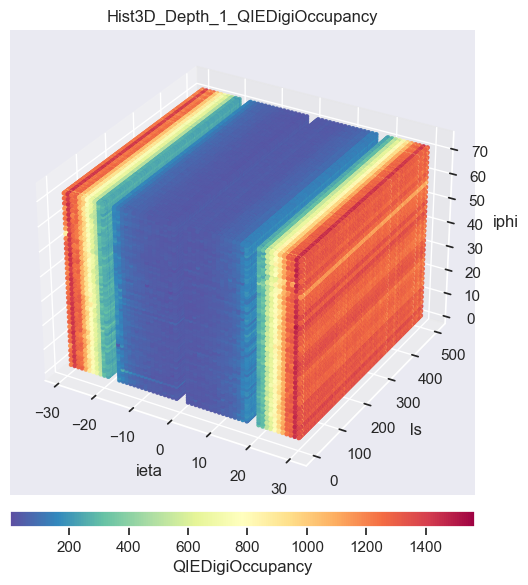

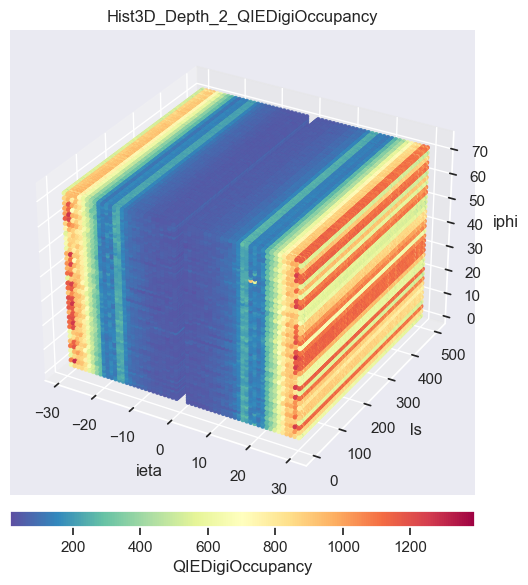

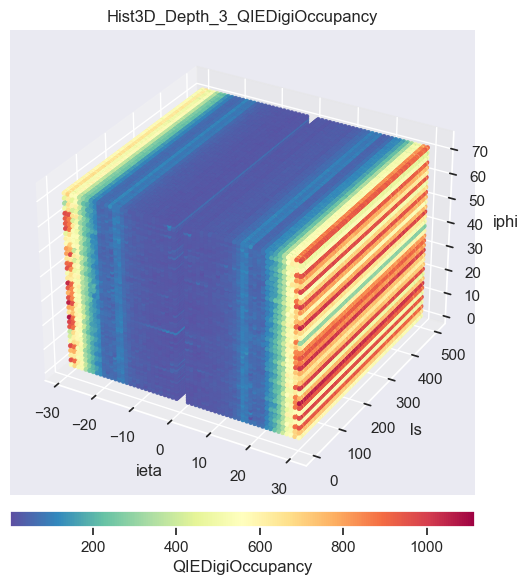

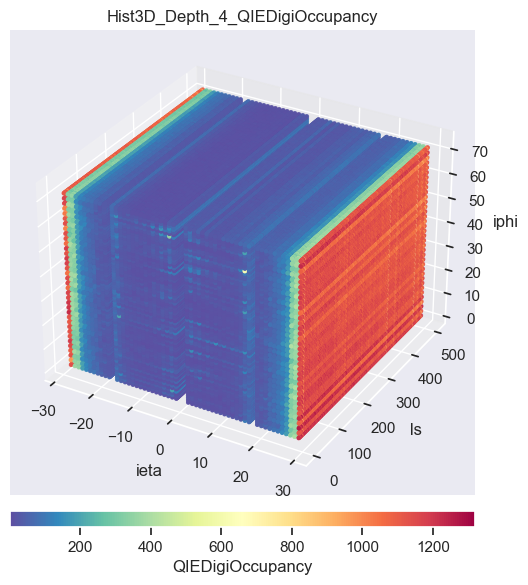

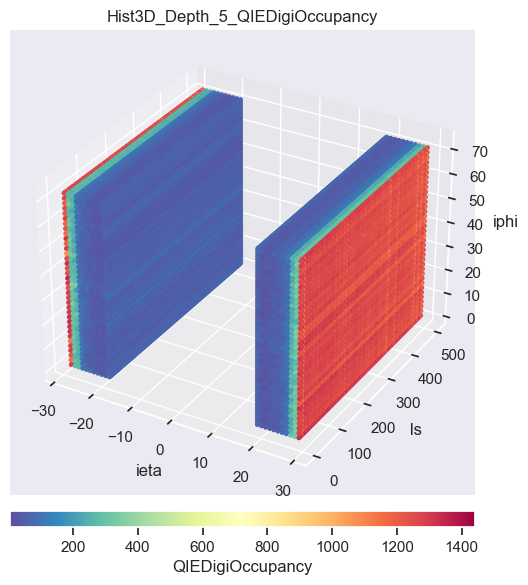

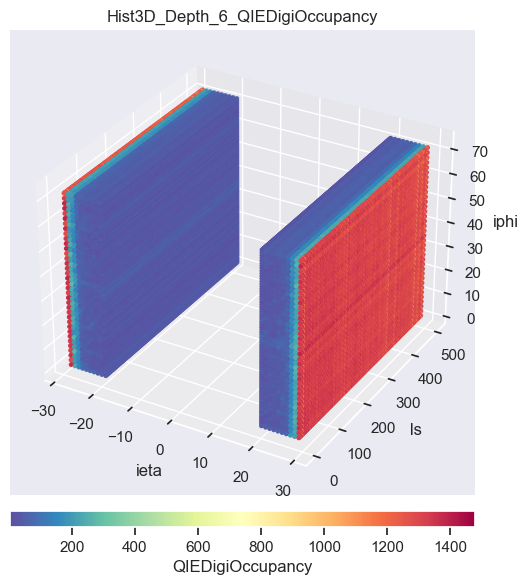

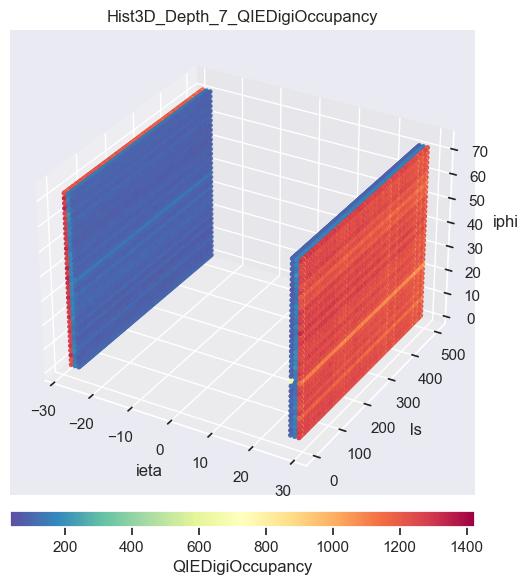

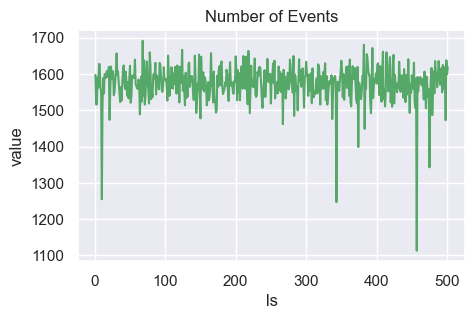

root_th3_with_lumi_to_numpy_convert... Hcal4DQMAnalyzer/evttree/RunNum
(1, 2)
####################################################################################################
CONVERSION SUMMARY REPORT
RunId:  355456
Digioccupancy data size:  (502, 64, 72, 7, 1)
Run setting sata size:  (501, 1)
Run setting sata size:      NumEvents
ls           
1        1598
2        1516
3        1517
4        1591
5        1563
Meta data:  {'xaxis': {'label': 'ls', 'values': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94, 

In [379]:
filepath = r"C:\Users\mulugetawa\OneDrive - Universitetet i Agder\CERN\InductionProject\DESMOD_PROD\data\rootfiles\DIGIOCCUPANCY/Run355456__hehb_cut20fc__depth.root"
TH3Obj_np, run_ls_lumi_df, meta_data = rootfile_loader(filepath, depth_size=7, isrun_setting=True, isplot=True)

In [380]:
filepath = r"C:\Users\mulugetawa\OneDrive - Universitetet i Agder\CERN\InductionProject\DESMOD_PROD\data\rootfiles\DIGIOCCUPANCY\Run355456__hehb_cut20fc__depth.root"
TH3Obj_np, run_ls_lumi_df, meta_data = rootfile_loader(filepath, depth_size=7, isrun_setting=True, isplot=False)

rootfile_loader...,  C:\Users\mulugetawa\OneDrive - Universitetet i Agder\CERN\InductionProject\DESMOD_PROD\data\rootfiles\DIGIOCCUPANCY\Run355456__hehb_cut20fc__depth.root
root_th3_with_lumi_to_numpy_convert... Hcal4DQMAnalyzer/hist3D
Hcal4DQMAnalyzer/hist3D_depth1
hist dim: ls=2001, ieta=65, iphi=73
hist axis index limits: ls=[0.0, 2000.0], ieta=[-32.0, 32.0], iphi=[0.0, 72.0]
(502, 64, 72)
Hcal4DQMAnalyzer/hist3D_depth2
hist dim: ls=2001, ieta=65, iphi=73
hist axis index limits: ls=[0.0, 2000.0], ieta=[-32.0, 32.0], iphi=[0.0, 72.0]
(502, 64, 72)
Hcal4DQMAnalyzer/hist3D_depth3
hist dim: ls=2001, ieta=65, iphi=73
hist axis index limits: ls=[0.0, 2000.0], ieta=[-32.0, 32.0], iphi=[0.0, 72.0]
(502, 64, 72)
Hcal4DQMAnalyzer/hist3D_depth4
hist dim: ls=2001, ieta=65, iphi=73
hist axis index limits: ls=[0.0, 2000.0], ieta=[-32.0, 32.0], iphi=[0.0, 72.0]
(502, 64, 72)
Hcal4DQMAnalyzer/hist3D_depth5
hist dim: ls=2001, ieta=65, iphi=73
hist axis index limits: ls=[0.0, 2000.0], ieta=[-32.0, 32

In [382]:
# run_ls_lumi_df.head()
# meta_data

# Scripts

In [ ]:
# set file path
filepath = r"..\data\HBHE\Run355456__hehb_cut20fc__depth.root" # change path to your local path

In [ ]:
# with plots
TH3Obj_np, run_ls_lumi_df, meta_data = rootfile_loader(filepath, depth_size=7, isrun_setting=True, isplot=True) # change depth_size according to the included number of hist3d_depthX histograms in the root file

In [ ]:
# or without plots, faster processing
TH3Obj_np, run_ls_lumi_df, meta_data = rootfile_loader(filepath, depth_size=7, isrun_setting=True, isplot=False)